In [1]:
import sys
import os

from argparse import ArgumentParser

import torch
from pytorch_base.experiment import PyTorchExperiment
from pytorch_base.base_loss import BaseLoss

import random
from tqdm.auto import tqdm

from diffusers import UNet1DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

import numpy as np
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

import lovely_tensors as lt
lt.monkey_patch()


/Users/lfbarba/opt/miniconda3/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
brain2_coords = torch.tensor(np.load('data/brain2_coords.npy'))
brain2_sections = torch.tensor(np.load('data/brain2_sections.npy'))
integer_brain_coord = torch.tensor(np.load('data/integer_brain_coord.npy'))
reference_image = torch.tensor(np.load('data/reference_image.npy').astype(np.int16))
tissue_density = torch.tensor(np.load('data/tissue_density.npy'))
brain2_slices_rs = torch.tensor(np.load('data/brain2_slices_rs.npy'))
brain2_slices_rs

tensor[1918708, 156] f64 n=299318448 x∈[-0.692, 12.450] μ=-7.342e-17 σ=1.000

In [3]:
volume = torch.zeros_like(reference_image, dtype=torch.float64)
volume[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2]] =  brain2_slices_rs[:, 100].clone()

slices = torch.zeros_like(reference_image, dtype=torch.long)
slices[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2]] =  brain2_sections.clone()

In [88]:
import napari
import numpy as np

viewer = napari.view_image(volume.detach().numpy(), ndisplay=3)  # 'ndisplay=3' for 3D viewing


Traceback (most recent call last):
  File "/Users/lfbarba/opt/miniconda3/lib/python3.9/site-packages/napari/_qt/qt_main_window.py", line 572, in closeEvent
    quit_app()
  File "/Users/lfbarba/opt/miniconda3/lib/python3.9/site-packages/napari/_qt/qt_event_loop.py", line 232, in quit_app
    v.close()
  File "/Users/lfbarba/opt/miniconda3/lib/python3.9/site-packages/napari/viewer.py", line 146, in close
    self.window.close()
  File "/Users/lfbarba/opt/miniconda3/lib/python3.9/site-packages/napari/_qt/qt_main_window.py", line 1525, in close
    self._qt_viewer.close()
RuntimeError: wrapped C/C++ object of type QtViewer has been deleted


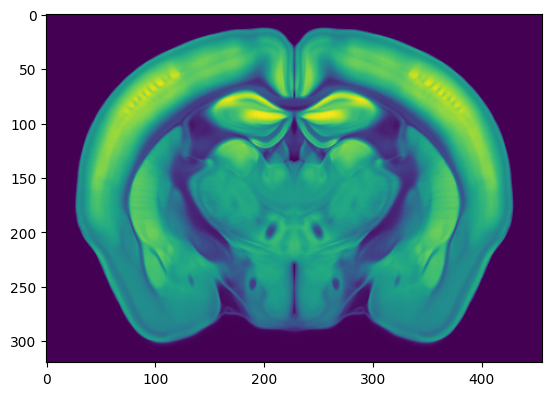

In [5]:
plt.imshow(reference_image[260])

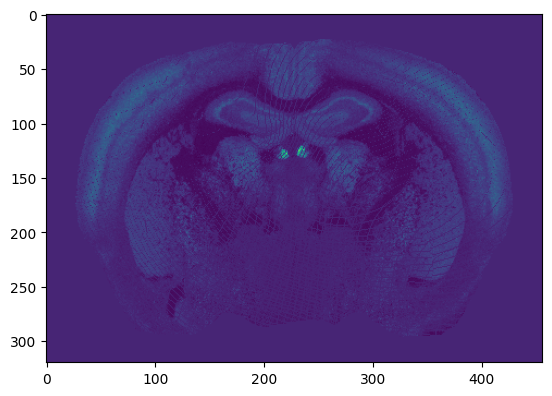

In [90]:
plt.imshow(volume[260])

# Slices

In [6]:
import torch
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
from torch.nn.functional import normalize

V = volume.clone().float()
mask = slices == 20

# Example setup: Let's assume V is your 3D volume tensor and mask is a boolean tensor of the same shape
# V.shape = (D, H, W), mask.shape = (D, H, W)
D, H, W = mask.shape
V = volume.clone()

# Step 1: Extract the coordinates of the masked points
coordinates = torch.nonzero(mask.permute(1, 2, 0), as_tuple=False).long()  # Shape: (N, 3), where N is the number of points
# coordinates = torch.cartesian_prod(torch.arange(D), torch.arange(H), torch.arange(W))
# coordinates = coordinates[mask.view(-1)]
# coordinates contains points as (z, y, x)

# Step 2: Fix one point as the origin
origin = coordinates[0].float()  # Choose the first point in the mask as the origin

# Step 3: Calculate the offsets by subtracting the origin
shifted_coordinates = coordinates - origin  # Shape: (N, 3)
shifted_coordinates = shifted_coordinates[1:]


In [75]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from PySide6.QtCore import Qt
# from PySide6.QtWidgets import QApplication, QLabel
%matplotlib qt

vectors = normalize(shifted_coordinates)

fig = plt.figure(figsize = (10, 10))
axes = plt.axes(projection = '3d')
plt.title("Dynamic Axes")

axes.scatter3D(0, 0, 0, s=20, alpha=0.7, color='r', marker="o")

axes.scatter3D(v[0], v[1], v[2], color='b', s=20)
axes.scatter3D(vectors[perm][:, 0], vectors[perm][:, 1], vectors[perm][:, 2], color=(0, 1, 1, 0.2), s=1)
axes.scatter3D(normals[:, 0], normals[:, 1], normals[:, 2], color='k', s=20)



plt.show()


In [74]:
vectors @ orthogonal

tensor[54720] x∈[-0.006, 0.689] μ=0.003 σ=0.009

In [73]:
num_pairs = len(shifted_coordinates)//2
random_perm = torch.randperm(len(shifted_coordinates))
normals = torch.cross(shifted_coordinates[random_perm][:num_pairs], shifted_coordinates[random_perm][num_pairs:2*num_pairs])
normals = normals[(normals.norm(dim=-1) >5000)]
normals = torch.abs(normalize(normals))
orthogonal = normalize(normals.mean(dim=0).unsqueeze(0))[0]
orthogonal, shifted_coordinates @ orthogonal


(tensor[3] x∈[0.004, 0.971] μ=0.405 σ=0.504 [0.240, 0.004, 0.971],
 tensor[54720] x∈[-1.486, 1.686] μ=0.189 σ=0.584)

In [268]:
orthogonal = normalize(orthogonal.unsqueeze(0))[0]
orthogonal

tensor[3] x∈[-0.655, 0.655] μ=-0.126 σ=0.690 [-0.377, 0.655, -0.655]

In [76]:
import torch
import torch.nn.functional as F
import numpy as np

def rotate_volume(V, p):
    # Step 1: Normalize the vector p
    p = p / torch.norm(p)

    # Step 2: Calculate the rotation axis and angle
    z_axis = torch.tensor([0.0, 0.0, 1.0], dtype=torch.float)
    axis = torch.cross(p, z_axis)
    axis_norm = torch.norm(axis)

    # If the axis norm is zero, then p is already aligned with z-axis
    if axis_norm == 0:
        return V  # No rotation needed
    
    axis = axis / axis_norm  # Normalize the rotation axis
    angle = torch.acos(torch.dot(p, z_axis))  # Angle between p and z-axis

    # Step 3: Construct the rotation matrix using Rodrigues' rotation formula
    K = torch.tensor([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]], dtype=torch.float)

    I = torch.eye(3)
    R = I + torch.sin(angle) * K + (1 - torch.cos(angle)) * (K @ K)

    # Step 4: Apply the rotation to the volume V
    # Create a grid of coordinates representing the volume
    D, H, W = V.shape
    z, y, x = torch.meshgrid(
        torch.linspace(-1, 1, D), torch.linspace(-1, 1, H), torch.linspace(-1, 1, W), indexing='ij'
    )
    coords = torch.stack([x, y, z], dim=-1).reshape(-1, 3)  # Shape: (D*H*W, 3)

    # Apply the rotation matrix to the coordinates
    rotated_coords = coords @ R.T

    # Reshape the rotated coordinates back to grid form and normalize to [-1, 1]
    rotated_coords = rotated_coords.reshape(D, H, W, 3)
    rotated_coords = rotated_coords.permute(3, 0, 1, 2)  # Shape: (3, D, H, W)

    # Normalize rotated coordinates to the range [-1, 1]
    rotated_coords[0] = rotated_coords[0] / torch.max(torch.abs(rotated_coords[0]))
    rotated_coords[1] = rotated_coords[1] / torch.max(torch.abs(rotated_coords[1]))
    rotated_coords[2] = rotated_coords[2] / torch.max(torch.abs(rotated_coords[2]))

    rotated_coords = rotated_coords.permute(1, 2, 3, 0).unsqueeze(0)  # Shape: (1, D, H, W, 3)

    # Reshape volume V for grid sampling
    V_reshaped = V.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, D, H, W)

    # Use grid_sample to interpolate the volume based on the rotated coordinates
    rotated_volume = F.grid_sample(V_reshaped, rotated_coords, align_corners=True, mode='bilinear')

    # Remove batch and channel dimensions
    return rotated_volume.squeeze()



In [77]:
masked_V = V.clone()
masked_V[~mask] *= 0.
rotated_V = rotate_volume(mask.float(), orthogonal)
print(rotated_V.shape)  # Should be the same shape as V: (D, H, W)

torch.Size([528, 320, 456])


In [134]:
# import napari
# import numpy as np

# viewer = napari.view_image(rotated_V.detach().numpy(), ndisplay=3)  # 'ndisplay=3' for 3D viewing


In [12]:
section = torch.tensor(np.load("data/sections/section10.npy"))
section

tensor[281, 421, 157] f64 n=18573257 x∈[-0.589, 280.000] μ=0.681 σ=10.734

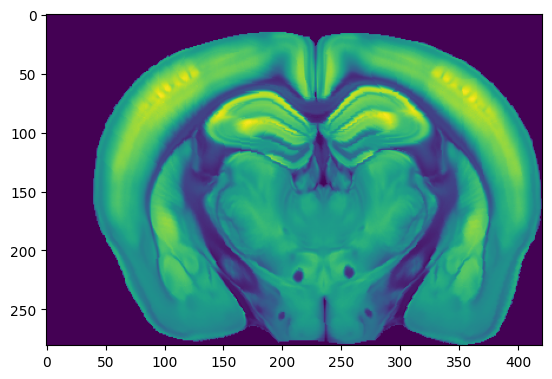

In [13]:
plt.imshow(section[:, :, -1])

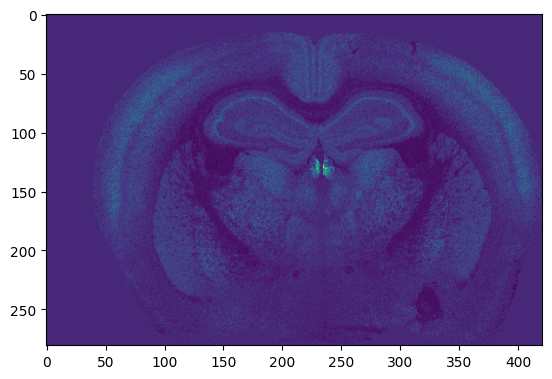

In [14]:
plt.imshow(section[:, :, 100])

# Dataset

In [4]:
import sys
import os

from argparse import ArgumentParser

import torch
from pytorch_base.experiment import PyTorchExperiment
from pytorch_base.base_loss import BaseLoss

import random
from tqdm.auto import tqdm

from diffusers import UNet1DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

import numpy as np
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

import lovely_tensors as lt
lt.monkey_patch()


In [5]:
def apply_circle_mask(img):
    W, H = img.shape[-2:]
    cp = torch.cartesian_prod(torch.arange(W, device=img.device), torch.arange(H, device=img.device))
    circle_mask = (cp[:, 0] - W / 2) ** 2 + (cp[:, 1] - W / 2) ** 2 <= (W / 2) ** 2
    return img * circle_mask.reshape(img.shape[-2:])

In [6]:
from mice.datasets.slice_dataset import SliceDataset
import lovely_tensors as lt
import os
lt.monkey_patch()

DATA_PATH = '/mydata/chip/shared/data' if torch.cuda.is_available() else 'data'

means = torch.tensor(np.load("means.npy"))
stds = torch.tensor(np.load("stds.npy"))


kwargs = {
    'path': 'data/sections',
    'im_size':32,
    'train_transform': True,
#     'rotation_angle': 30,
#     'rescale': 100,
    'stds':stds,
    'means':means
}

trainSet = SliceDataset(**kwargs)
print(trainSet[100])

tensor[2, 157, 32] n=10048 x∈[-1.862, 2.657] μ=0.046 σ=0.776


In [109]:
_, s = trainSet[0]
s

tensor[157, 32] n=5024 x∈[-1.675, 2.005] μ=0.824 σ=0.929

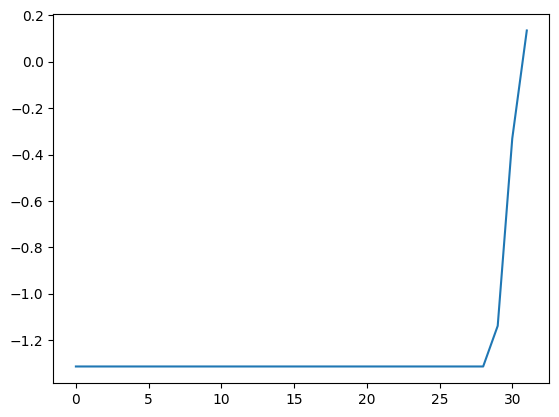

In [110]:
plt.plot(s[-1])

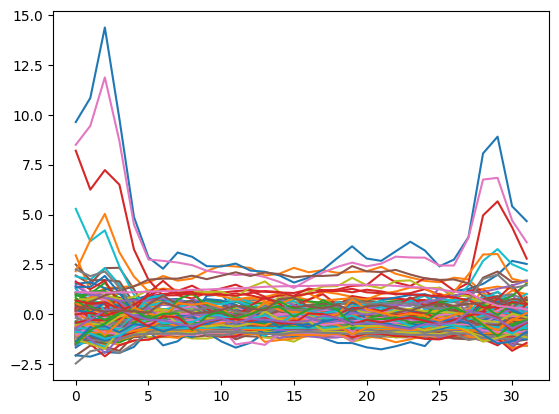

In [59]:
plt.plot(s.T)

# compute mean and std

In [ ]:
from tqdm.auto import tqdm
s_list = []
for _ in tqdm(range(10000)):
    s = trainSet[i]
    s_list.append(s)
samples = torch.stack(s_list)
samples

In [38]:
# np.save("stds", stds)
# np.save("means", means)

In [83]:
stds = []
means = []
flat_samples = samples.flatten(0, 1)
for i in range(157):
    stds.append(flat_samples[:, i].std())
    means.append(flat_samples[:, i].mean())
stds = torch.stack(stds)
means = torch.stack(means)

norm_samples = (flat_samples - means[None, :, None]) / stds[None, :, None]
norm_samples

tensor[10664, 157, 32] n=53575936 x∈[-5.662, 56.431] μ=8.816e-09 σ=1.000

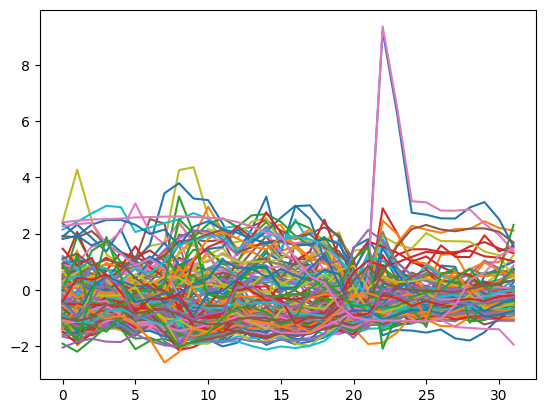

In [84]:
plt.plot(norm_samples[0].T)

# Testing Diffussion model

In [4]:
from diffusers import UNet1DModel
from main import load_model
device = torch.device('mps') if torch.backends.mps.is_built() else torch.device('mps')
model = UNet1DModel(
        sample_size=32,  # Adjusted to 32
        in_channels=2,
        out_channels=2,
        layers_per_block=1,
        block_out_channels=(32, 64),  # Reduced the number of output channels per block
        down_block_types=(
            "DownBlock1D",  # Keep the same
            "AttnDownBlock1D",  # One less downsampling block
        ),
        up_block_types=(
            "AttnUpBlock1D",  # Keep the same
            "UpBlock1D",  # Reduced the number of upsampling blocks accordingly
        ),
    ).to(device)
load_model(model, "checkpoints/random_experiment.pt")
# model.eval()
""

models loaded from checkpoint checkpoints/random_experiment.pt


''

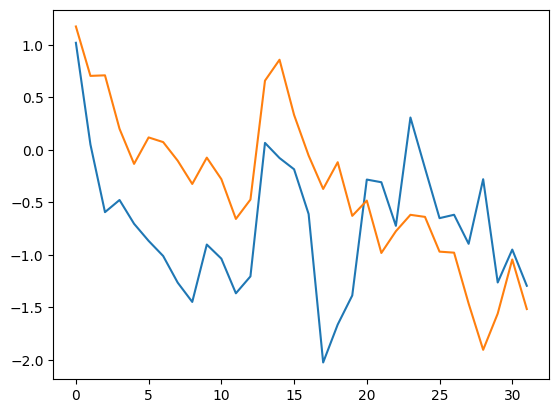

In [5]:
# load dataset
from main import get_dataset
means = torch.tensor(np.load("means.npy"))
stds = torch.tensor(np.load("stds.npy"))
kwargs = {
    "path": "data/sections",
    'im_size':32,
    "train_transform": True,
    'stds': stds,
    'means': means
}

trainSet, testSet = get_dataset(kwargs)
target = testSet[0][:1]
target
plt.plot(target[0, 0])
plt.plot(target[0, 100])

# Testing diffusion on one sample

In [6]:
with torch.no_grad():
    target = torch.stack([target[:, 0], target[:, 100]], 1)
target

tensor[1, 2, 32] n=64 x∈[-2.024, 1.174] μ=-0.533 σ=0.709

In [9]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler.config.clip_sample = True
noise_scheduler.config.clip_sample_range = 5.0

timestep = torch.LongTensor([300]).to(device)
noise = torch.randn_like(target[:, 0]).to(device)
expanded_noise = noise.repeat(target.shape[1], 1, 1).transpose(0, 1)
x_t = noise_scheduler.add_noise(target.to(device), expanded_noise, timestep).to(device)

# we predict the noise for this step t
with torch.no_grad():
    x_0_pred = model(x_t, timestep=timestep, return_dict=False)[0]
    
#     fading_factor = noise_scheduler.add_noise(torch.ones(1), torch.zeros(1), timestep).to(device)
#     noise_factor = noise_scheduler.add_noise(torch.zeros(1), torch.ones(1), timestep).to(device)

#     x_0_pred = (x_t - noise_factor * noise_pred) / fading_factor
#     x_0_pred = noise_scheduler.step(noise_pred.repeat(target.shape[1], 1, 1).transpose(0, 1), timestep.item(), x_t).pred_original_sample


# plot_tomogram_overview(x_0_pred[0].cpu().detach().clip(0, 1))
mse = torch.nn.MSELoss()
loss = mse(x_0_pred, target.to(device))
loss

tensor mps:0 0.298

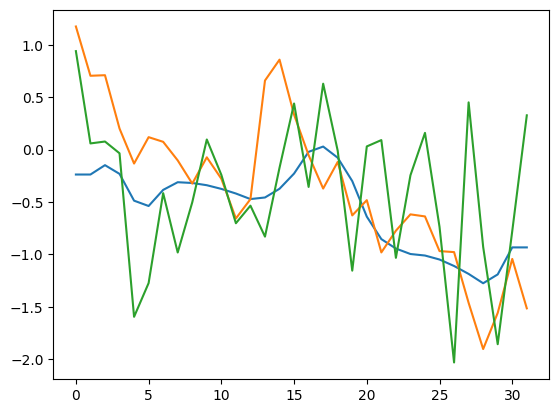

In [10]:
channel = 1
plt.plot(x_0_pred[0, channel].cpu())
plt.plot(target[0, channel].cpu())
plt.plot(x_t[0, channel].cpu())

In [11]:
import torch.nn.functional as F
padded_reference = F.pad(reference_image, (0, 24, 0, 0, 0, 16))
padded_reference

tensor[544, 320, 480] i16 n=83558400 x∈[0, 516] μ=55.155 σ=77.349

In [12]:
indices = [0, 100]
volume = torch.zeros((*padded_reference.shape, 2), dtype=torch.float32)
volume[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2]] =  brain2_slices_rs[:, indices].clone().float()
volume

tensor[544, 320, 480, 2] n=167116800 x∈[-0.676, 4.674] μ=-0.001 σ=0.039

In [72]:
def flatten(permutation, volume, size=32):
    return volume.permute(permutation).flatten(0, 1).unfold(dimension=1, size=size, step=size).flatten(0, 1)

def unflatten(permutation, flat_volume, shape):
    size = flat_volume.shape[-1]
    permuted_shape = [shape[i] for i in permutation]
    inverse_permutation = [x.item() for x in torch.tensor(permutation).sort().indices]
    unfolded_volume = flat_volume.unflatten(0, (-1, permuted_shape[-2]//size)).transpose(-1, -2).flatten(-3, -2)
    return unfolded_volume.reshape(permuted_shape, 2).permute(inverse_permutation)

permutation = (2, 1, 0, 3)
unflatten(permutation,  flatten(permutation, volume), volume.shape) - volume

544 32


tensor[544, 320, 480, 2] all_zeros

In [73]:
flatten(permutation, volume)

tensor[2611200, 2, 32] n=167116800 x∈[-0.676, 4.674] μ=-0.001 σ=0.039

In [116]:
import torch.nn as nn
class BrainSliceDiffusion(nn.Module):
    def __init__(self, image_shape, channels_indices, unet, buffer=5):
        super(BrainSliceDiffusion, self).__init__()
        self.unet = unet
        self.volume = nn.Parameter(torch.zeros(*image_shape, len(channels_indices)))
        self.buffer = buffer
        self.channels = channels_indices

    def inpainting(self, pred_x_0, integer_brain_coord, brain2_slices_rs, reference_image):
        with torch.no_grad():
            device = pred_x_0.device
            pred_x_0[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2]] *= 0
            pred_x_0[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2]] +=  brain2_slices_rs[:, self.channels].clone().float().to(device)
            pred_x_0[:, :, :, -1] *= 0
            pred_x_0[:, :, :, -1] += reference_image.to(device)
        return pred_x_0

    def predict_x_0(self, t, x_t, noise_scheduler):
        device = self.volume.device
        timesteps = torch.LongTensor([t]).to(device)
        x_0_pred = self.unet(x_t, timesteps, return_dict=False)[0]
        
        return x_0_pred

    def step(self, t, target_t, x_t, noise_scheduler):
        device = self.volume.device
        x_0_pred = self.predict_x_0(t, x_t, noise_scheduler)
        new_timestep = torch.LongTensor([target_t]).to(device)
        new_x_t = noise_scheduler.add_noise(x_0_pred, torch.randn_like(x_0_pred), new_timestep).to(device)

        return new_x_t, noise_pred

    def diffusion_pipeline(self, x_t_start, t_start, t_end, noise_scheduler, num_steps=50, verbose=False):
        device = self.volume.device
        with torch.no_grad():
            x_t = x_t_start.clone()

            timesteps = torch.linspace(t_start, t_end, num_steps + 1).int()
            for i in tqdm(range(1, len(timesteps)), disable=not verbose):
                t = timesteps[i - 1]
                target_t = timesteps[i]
                x_t, _ = self.step(t, target_t, x_t, noise_scheduler)
            return x_t

    def guided_diffusion_pipeline(
        self, x_t_start, t_start, t_end, noise_scheduler, num_steps,
        integer_brain_coord, brain2_slices_rs, reference_image,
        batch_size, verbose=True
    ):
        device = self.volume.device
        x_t = x_t_start.clone()

        timesteps = torch.linspace(t_start, t_end + self.buffer, num_steps + 1).int()
        for i in tqdm(range(1, len(timesteps)), disable=not verbose):
            t = timesteps[i - 1]
            target_t = timesteps[i]
            
            with torch.no_grad():
                permutation = [0, 1, 2, 3]
                axial_batches = flatten(permutation, x_t)
                predictions = []
                assert(len(axial_batches) % batch_size == 0)
                for x_t_batch in tqdm(axial_batches.unfold(dimension=0, size=batch_size, step=batch_size).permute(0, 3, 1, 2)):
                    predictions.append(self.predict_x_0(t, x_t_batch, noise_scheduler))
                pred_x_0 = torch.cat(predictions)
                pred_x_0 = unflatten(permutation, pred_x_0, x_t.shape)
            self.pred_x_0 = pred_x_0
            pred_x_0 = self.inpainting(pred_x_0, integer_brain_coord, brain2_slices_rs, reference_image)

            new_timestep = torch.LongTensor([target_t]).to(device)
            x_t = noise_scheduler.add_noise(pred_x_0, torch.randn_like(pred_x_0), new_timestep).to(device)


#         x_t = self.diffusion_pipeline(
#             x_t, t_end + self.buffer, t_end,
#             noise_scheduler, num_steps=self.buffer,
#             verbose=verbose
#         )

        return x_t


In [123]:
bsd.pred_x_0[:, :, :, -1], padded_reference

(tensor[544, 320, 480] all_zeros mps:0,
 tensor[544, 320, 480] i16 n=83558400 x∈[0, 516] μ=55.155 σ=77.349)

In [124]:
bsd.inpainting(bsd.pred_x_0, integer_brain_coord, brain2_slices_rs, padded_reference)

tensor[544, 320, 480, 2] n=167116800 x∈[-3.213, 516.000] μ=27.578 σ=61.254 mps:0

In [125]:
T = torch.LongTensor([999]).to(device)
noise = torch.randn_like(volume)
x_T = noise_scheduler.add_noise(volume, noise, T).to(device)

bsd = BrainSliceDiffusion(volume.shape, channels_indices=[100], unet=model).to(device)

res = bsd.guided_diffusion_pipeline(
    x_t_start = x_T, t_start=999, t_end=0, noise_scheduler=noise_scheduler, num_steps=1,
    integer_brain_coord=integer_brain_coord, brain2_slices_rs=brain2_slices_rs, reference_image=padded_reference,
    batch_size=320, verbose = True
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8160 [00:00<?, ?it/s]

480 32


RuntimeError: The size of tensor a (2) must match the size of tensor b (32) at non-singleton dimension 3

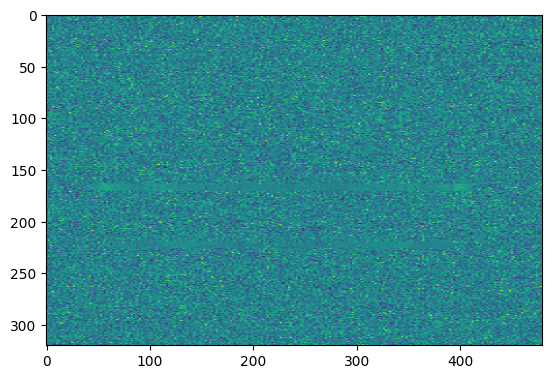

In [131]:
plt.imshow(bsd.pred_x_0[:, :, :, 0][202].cpu())